In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from functions_SqRA import grid1, adjancency_matrix_sparse, build_sqra, build_sqra_dec1


np.random.seed(0) 

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

## System parameters

In [2]:
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu mol-1
gamma  = 1                           # ps-1 
D      = kB * T / mass / gamma       # nm2 ps-1
sigma  = np.sqrt(2 * D)              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

## Potential energy function

In [3]:
def V1(x):
    return 1*(x**2 - 1) ** 2 + x

def V2(y):
    return 2*y ** 2

def V12(x,y):
    return x * y
    #return 1/np.sqrt(x**2 + y**2)

"""def V12(x,y):
    par_coulomb  = 1
    par_lj       = np.array([2, 0.5])
        
    tol = 1e-5    
    norm_rij = np.sqrt((x-y)**2 + 1) #np.sqrt(x**2 + y**2)
    
    V12 = np.zeros(norm_rij.shape)
    
    V12[norm_rij<tol] = np.inf
    norm_rij[(norm_rij > tol) & (norm_rij < par_lj[1])] = par_lj[1]

    return -1 * par_coulomb ** 2 / norm_rij + \
                     4*par_lj[0] * (( par_lj[1] / norm_rij ) ** 12 - ( par_lj[1] / norm_rij ) ** 6)
"""

def V(c, X):
    
    return V1(X[0]) + V2(X[1]) + c * V12(X[0], X[1])


#### Figure 2D potential

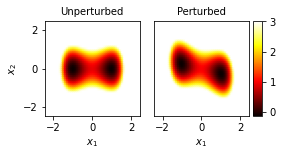

In [4]:
xcenters, xedges, xbins, dx = grid1(-2.5, 2.5, 50)
ycenters, yedges, ybins, dy = grid1(-2.5, 2.5, 50)

grid = np.meshgrid(xcenters, ycenters)
X    = np.stack([grid[0], grid[1]])
V0n   = V(0, X)
V1n   = V(1, X)

# Plot potential
fig = plt.figure(figsize=(8*in2cm, 4*in2cm))

###################################################################### 2D 


ax = fig.add_subplot(1, 2, 1)

pos = ax.pcolormesh(X[0], X[1], V0n, shading='gouraud', vmax = 3, cmap = cm.hot)

ax.set_title('Unperturbed', fontsize = 10)
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

ax = fig.add_subplot(1, 2, 2)

pos = ax.pcolormesh(X[0], X[1], V1n, shading='gouraud', vmax = 3, cmap = cm.hot)

ax.set_title('Perturbed', fontsize = 10)
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$x_1$')
ax.set_yticks([])

#ax.set_ylabel('y')

cbar_ax = fig.add_axes([0.92, 0.085, 0.04, 0.83])
fig.colorbar(pos, cax=cbar_ax)


plt.subplots_adjust(left=0, bottom=0, right=0.9, top=1, wspace=0.15, hspace=0)
#fig.savefig('figures/potentials_2D.pdf', format='pdf', dpi=900, bbox_inches='tight')

## Grid definition

In [5]:
# Number of dimensions
Nd       = 2

a = 3.4
xcenters, xedges, xbins, dx = grid1(-a, a, 51)
ycenters, yedges, ybins, dy = grid1(-a, a, 51)

bins = np.array([xbins, ybins])
DX   = np.array([dx, dy])

grid = np.meshgrid(xcenters, ycenters)
X    = np.stack([grid[0], grid[1]])

# Total number of bins
Nbins = xbins * ybins
print("Total number of bins: ", Nbins)

Total number of bins:  2500


# Uncoupled Potential $c=0$
### SqRA of the full system

In [6]:
# Coupling coefficient
c = 0

# Stationary distribution
pi0 = np.exp(- beta * V(c, X).flatten('C') )

## SqRA
# Qd  : rate matrix D-1 A D - E
# Qc  : rate matrix from PCCA+
# chi : membership functions
# Qo  : matrix D-1 A D
Qd, Qc, chi, Qo = build_sqra(D, pi0, DX, bins)

# Eigenvalue problem
eigenval_c0,    eigenvec_c0    = scipy.sparse.linalg.eigs(Qd, 4, which='LR')
eigenval_Qo_c0, eigenvec_Qo_c0 = scipy.sparse.linalg.eigs(Qo, 4, which='LR')

### SqRA of the sub-systems

In [7]:
# Stationary distributions
pi1 = np.exp(- beta * V1(xcenters) )
pi2 = np.exp(- beta * V2(ycenters) )

PI = np.array([pi1, pi2], dtype=object)

## SqRA
Ai, Ii, Qoi, Ei =  build_sqra_dec1(D, PI, DX, bins)


# Eigenvalue problem of the subsystems
eigenval_i  = np.empty(Nd, dtype=object)
eigenvec_i  = np.empty(Nd, dtype=object)

# Entropical matrix
e_i         = np.empty(Nd, dtype=object)
Ei2         = np.empty(Nd, dtype=object)
Qi          = np.empty(Nd, dtype=object)

for i in range(Nd):
    e_i[i]                       = np.ones(bins[i])
    Ei2[i]                       = scipy.sparse.spdiags( Qoi[i] * e_i[i], 0, bins[i], bins[i] ) 
    Qi[i]                        = Qoi[i] - Ei2[i]
    eigenval_i[i], eigenvec_i[i] = scipy.sparse.linalg.eigs(Qi[i], 4, which='LR')
    eigenvec_i[i][:,0]           = np.abs(eigenvec_i[i][:,0])
    
# Kronacker product / sum rules to estimate eigenvalues/eigenvectors of the full system
eigenval_d_c0 = np.zeros(4)
eigenvec_d_c0 = np.zeros((Nbins, 4))
k = 0
for i in range(2):
    for j in range(2):
        eigenval_d_c0[k]     = eigenval_i[0][j] + eigenval_i[1][i]
        eigenvec_d_c0[:,k] = np.diag( \
                                     scipy.sparse.kron( scipy.sparse.spdiags( eigenvec_i[1][:,i], 0, bins[1], bins[1] ) , \
                                                        scipy.sparse.spdiags( eigenvec_i[0][:,j], 0, bins[0], bins[0] )   \
                                                      ).toarray()
                                    )
        k = k + 1

# eigenval_d is equal to eigenval
# eigenvec_d is equal to eigenvec

/tmp/ipykernel_24248/3550267039.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenval_d_c0[k]     = eigenval_i[0][j] + eigenval_i[1][i]
/tmp/ipykernel_24248/3550267039.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvec_d_c0[:,k] = np.diag( \


# Coupled Potential $c=1$
### SqRA of the full system

In [8]:
# Coupling coefficient
c = 1

# Stationary distribution
pi = np.exp(- beta * V(c, X).flatten('C') )

## SqRA
# Qd  : rate matrix D-1 A D - E
# Qc  : rate matrix from PCCA+
# chi : membership functions
# Qo  : matrix D-1 A D
Qd, Qc, chi, Qo = build_sqra(D, pi, DX, bins)

# Eigenvalue problem
eigenval_c1, eigenvec_c1 = scipy.sparse.linalg.eigs(Qd, 4, which='LR')
eigenval_Qo_c1, eigenvec_Qo_c1 = scipy.sparse.linalg.eigs(Qo, 4, which='LR')

### SqRA of the sub-systems

In [9]:
# Stationary distributions
pi1  = np.exp(- beta * V1(xcenters) )
pi2  = np.exp(- beta * V2(ycenters) )
pi12 = np.exp(- beta * V12(X[0], X[1]).flatten('C') )
PI   = np.array([pi1, pi2], dtype=object)

## SqRA
#Ai, Ii, Qoi, Ei are lists containing the matrices of the uncoupled subsystems
Ai, Ii, Qoi, Ei =  build_sqra_dec1(D, PI, DX, bins)

# off-diagonal matrix of the uncoupled system
Qod             = 0

for i in range(Nd):
    Qod = scipy.sparse.kronsum(Qod, Qoi[i])
    
# Build D12inv and D12
SQRA   = np.sqrt(pi12)
D12    = scipy.sparse.spdiags( SQRA,     0, Nbins, Nbins) #.toarray()
D12inv = scipy.sparse.spdiags( 1 / SQRA, 0, Nbins, Nbins)  

# Multiply Qo by D12inv and D12
Qod     = D12inv * Qod * D12

# Build rate matrix Q
E      = scipy.sparse.spdiags( Qod.sum(axis=1).T, 0, Nbins, Nbins )
Q      = Qod - E 

eigenval_Qo_d_c1, eigenvec_Qo_d_c1  = scipy.sparse.linalg.eigs(Qod, 4, which='LR')
eigenval_d_c1,    eigenvec_d_c1     = scipy.sparse.linalg.eigs(Q,   4, which='LR')

print(eigenval_d_c1)

[ 3.18634008e-13+0.j -1.81750841e+00+0.j -4.31074085e+00+0.j
 -5.47000975e+00+0.j]


### Figures eigenvectors and eigenvalues

/tmp/ipykernel_24248/1758196960.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  e1_c1  =  - eigenvec_d_c1[:,1].astype('float').reshape(bins[0], bins[1])
/tmp/ipykernel_24248/1758196960.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  e2_c1  = -  eigenvec_d_c1[:,2].astype('float').reshape(bins[0], bins[1])
/tmp/ipykernel_24248/1758196960.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  e3_c1  =    eigenvec_d_c1[:,3].astype('float').reshape(bins[0], bins[1])


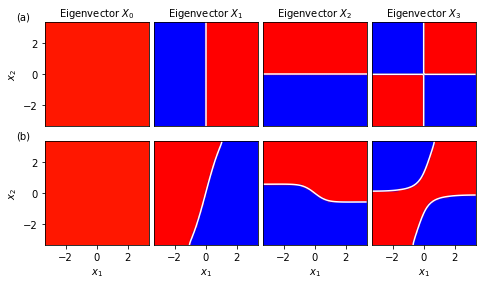

In [10]:
e0_c0  =   np.abs(eigenvec_d_c0[:,0]).reshape(bins[0], bins[1])

e1_c0   =   eigenvec_d_c0[:,1].reshape(bins[0], bins[1])
e1_c0_s = np.copy(e1_c0)
e1_c0_s[e1_c0_s>=0]  =  0.1
e1_c0_s[e1_c0_s<0]  =  -0.1

e2_c0  =   eigenvec_d_c0[:,2].reshape(bins[0], bins[1])
e2_c0_s = np.copy(e2_c0)
e2_c0_s[e2_c0_s>=0]  =  0.1
e2_c0_s[e2_c0_s<0]  =  -0.1


e3_c0  =   eigenvec_d_c0[:,3].reshape(bins[0], bins[1])
e3_c0_s = np.copy(e3_c0)
e3_c0_s[e3_c0_s>=0]  =  0.1
e3_c0_s[e3_c0_s<0]  =  -0.1

"""e0_c1  =   np.abs(eigenvec_c1[:,0]).astype('float').reshape(bins[0], bins[1])
e1_c1  =   eigenvec_c1[:,1].astype('float').reshape(bins[0], bins[1])
e2_c1  =   eigenvec_c1[:,2].astype('float').reshape(bins[0], bins[1])
e3_c1  = - eigenvec_c1[:,3].astype('float').reshape(bins[0], bins[1])
"""
e0_c1  =   np.abs(eigenvec_d_c1[:,0]).astype('float').reshape(bins[0], bins[1])
e0_c1_s = np.copy(e0_c1)
e0_c1_s[e0_c1_s>=0]  =  0.1
e0_c1_s[e0_c1_s<0]  =  -0.1

e1_c1  =  - eigenvec_d_c1[:,1].astype('float').reshape(bins[0], bins[1])
e1_c1_s = np.copy(e1_c1)
e1_c1_s[e1_c1_s>=0]  =  0.1
e1_c1_s[e1_c1_s<0]  =  -0.1

e2_c1  = -  eigenvec_d_c1[:,2].astype('float').reshape(bins[0], bins[1])
e2_c1_s = np.copy(e2_c1)
e2_c1_s[e2_c1_s>=0]  =  0.1
e2_c1_s[e2_c1_s<0]  =  -0.1

e3_c1  =    eigenvec_d_c1[:,3].astype('float').reshape(bins[0], bins[1])
e3_c1_s = np.copy(e3_c1)
e3_c1_s[e3_c1_s>=0]  =  0.1
e3_c1_s[e3_c1_s<0]  =  -0.1

plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(16*in2cm, 8*in2cm))

###################################################################### UNCOUPLED

# Eigenvector 0
ax  = fig.add_subplot(2, 4, 1)
pos = ax.pcolormesh(X[0], X[1], e0_c0, shading='gouraud', vmin = 0, vmax = 0.05, cmap = cm.hot)

ax.axis("square")
ax.set_xticks([])
ax.set_yticks([-2, 0, 2])
ax.set_ylabel(r"$x_2$")
ax.set_title(r"Eigenvector $X_0$", fontsize = 10)
ax.text(-5.2,3.5,'(a)')


# Eigenvector 1
ax = fig.add_subplot(2, 4, 2)
pos = ax.pcolormesh(X[0], X[1], e1_c0_s, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
#pos = ax.pcolormesh(X[0], X[1], e1_c0, shading='gouraud', vmin = -0.1, vmax = 0.1, cmap = cm.bwr)
ax.contour(X[0], X[1], e1_c0, 0, colors=('w', '1'))

ax.axis("square")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r"Eigenvector $X_1$", fontsize = 10)

# Eigenvector 2
ax = fig.add_subplot(2, 4, 3)
pos = ax.pcolormesh(X[0], X[1], e2_c0_s, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
ax.contour(X[0], X[1], e2_c0, 0, colors=('w', '1'))

ax.axis("square")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r"Eigenvector $X_2$", fontsize = 10)

# Eigenvector 3
ax = fig.add_subplot(2, 4, 4)
pos = ax.pcolormesh(X[0], X[1], e3_c0_s, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
#pos = ax.pcolormesh(X[0], X[1], e3_c0, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
ax.contour(X[0], X[1], e3_c0, 0, colors=('k', '0'), linewidths=1.2)
ax.contour(X[0], X[1], e3_c0, 0, colors=('w', '1'))

ax.axis("square")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r"Eigenvector $X_3$", fontsize = 10)


###################################################################### COUPLED

# Eigenvector 0
ax = fig.add_subplot(2, 4, 5)
#pos = ax.pcolormesh(X[0], X[1], e0_c1, shading='gouraud', vmin = 0, vmax = 0.05, cmap = cm.hot)
pos = ax.pcolormesh(X[0], X[1], e0_c1, shading='gouraud', vmin = 0, vmax = 0.05, cmap = cm.hot)
ax.axis("square")
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
#cbar_ax = fig.add_axes([0.02, -0.18, 0.2, 0.05])
#fig.colorbar(pos, cax=cbar_ax, orientation="horizontal")
ax.text(-5.2,3.5,'(b)')


# Eigenvector 1
ax = fig.add_subplot(2, 4, 6)
#pos = ax.pcolormesh(X[0], X[1], e1_c1, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
pos = ax.pcolormesh(X[0], X[1], -e1_c1_s, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
ax.contour(X[0], X[1], e1_c1, 0, colors=('w', '1'))

ax.axis("square")
ax.set_xlabel(r"$x_1$")
ax.set_xticks([-2, 0, 2])
ax.set_yticks([])

# Eigenvector 2
ax = fig.add_subplot(2, 4, 7)
#pos = ax.pcolormesh(X[0], X[1], -e2_c1, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
pos = ax.pcolormesh(X[0], X[1], -e2_c1_s, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
ax.contour(X[0], X[1], e2_c1, 0, colors=('w', '1'))

ax.axis("square")
ax.set_xlabel(r"$x_1$")
ax.set_xticks([-2, 0, 2])
ax.set_yticks([])

# Eigenvector 3
ax = fig.add_subplot(2, 4, 8)
#pos = ax.pcolormesh(X[0], X[1], e3_c1, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
pos = ax.pcolormesh(X[0], X[1], -e3_c1_s, shading='gouraud', vmin = -0.05, vmax = 0.05, cmap = cm.bwr)
ax.contour(X[0], X[1], e3_c1, 0, colors=('w', '1'))

ax.axis("square")
ax.set_xlabel(r"$x_1$")
ax.set_xticks([-2, 0, 2])
ax.set_yticks([])
#cbar_ax = fig.add_axes([0.5, -0.18, 0.2, 0.05])
#fig.colorbar(pos, cax=cbar_ax, orientation="horizontal")



#fig.colorbar(pos, cax=cbar_ax)


plt.subplots_adjust(left=0, bottom=0, right=0.95, top=1, wspace=0.05, hspace=0.1)
#fig.savefig('figures/eigenvectors.pdf', format='pdf', dpi=900, bbox_inches='tight')

[ 3.18634008e-13+0.j -1.81750841e+00+0.j -4.31074085e+00+0.j
 -5.47000975e+00+0.j]


/scratch/htc/ldonati/anaconda3/envs/emma/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


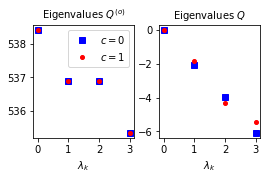

In [11]:
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(8*in2cm, 4*in2cm))

ax = fig.add_subplot(1, 2, 1)
ax.plot(eigenval_Qo_c0, 'bs', label = r"$c=0$")
#ax.plot(eigenval_Qo_c1, 'ro', label = r"$c=1$", markersize = 4)
ax.plot(eigenval_Qo_d_c1, 'ro', label = r"$c=1$", markersize = 4)
ax.set_xticks([0, 1, 2, 3]);
ax.set_title(r"Eigenvalues $Q^{(o)}$", fontsize = 10)
ax.set_xlabel(r"$\lambda_k$")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(eigenval_d_c0, 'bs', label = r"$c=0$")
ax.plot(eigenval_d_c1,   'ro', label = r"$c=1$", markersize = 4)
ax.set_xticks([0, 1, 2, 3]);
ax.set_title(r"Eigenvalues $Q$", fontsize = 10)
ax.set_xlabel(r"$\lambda_k$")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.0)
#fig.savefig('figures/eigenvalues.pdf', format='pdf', dpi=900, bbox_inches='tight')

print(eigenval_d_c1)

In [12]:
#filename = 'results_exact.npy'
#np.save(filename, [X, e0_c0, e0_c1, e1_c1_s, e1_c1, e2_c1_s, e2_c1, e3_c1_s, e3_c1, eigenval_Qo_c0, eigenval_Qo_d_c1, eigenval_d_c0, eigenval_d_c1])

In [13]:
-1/eigenval_d_c0

array([4.28413437e+12, 4.77093326e-01, 2.50856725e-01, 1.64409727e-01])

In [14]:
-1/eigenval_d_c1

array([-3.13839695e+12+0.j,  5.50203782e-01-0.j,  2.31978686e-01-0.j,
        1.82815031e-01-0.j])